In [1]:
from extreme_classification.distributions import multivariate_logistic_distribution
from extreme_classification.extreme_dataset import ExtremeDataset, BivariateLogisticDataset
from extreme_classification.extreme_classifier import ExtremeClassifier

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
train_dataset = BivariateLogisticDataset(
    sizes=[250000, 250000],
    alphas=[0.1, 0.5],
    labels=[0, 1],
    ranktransform=True
)

test_dataset = BivariateLogisticDataset(
    sizes=[1000000, 1000000],
    alphas=[0.1, 0.5],
    labels=[0, 1],
    ranktransform=True
)

In [3]:
# Import random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

### Training on the whole dataset with Random Forest

In [4]:
rf = RandomForestClassifier(n_estimators=200, random_state=0, max_depth=10, n_jobs=-1)
rf.fit(train_dataset.X, train_dataset.labels)

print("Training done.")

predictions = rf.predict(test_dataset.X)

whole_accuracy = accuracy_score(test_dataset.labels, predictions)
print("Whole accuracy: ", whole_accuracy)

whole_hamming = hamming_loss(test_dataset.labels, predictions)
print("Whole hamming loss: ", whole_hamming)

Training done.
Whole accuracy:  0.793508
Whole hamming loss:  0.206492


### Training on the top k most extreme samples with Random Forest

In [5]:
train_dataset.dataframe = train_dataset.dataframe.sort_values(by="norm", ascending=False)
train_dataset.dataframe["x1"] = train_dataset.dataframe.iloc[:, 0]
train_dataset.dataframe["x2"] = train_dataset.dataframe.iloc[:, 1]
train_dataset.dataframe.drop(columns=[0, 1], inplace=True)

train_dataset.dataframe

,labels,norm,x1,x2
481903,1.0,500000.999993,250000.499997,250000.499997
456210,1.0,250000.500000,166667.000001,83333.500000
185684,0.0,250000.500000,125000.250000,125000.250000
412082,1.0,222222.666667,55555.666667,166667.000001
91782,0.0,171428.914286,100000.200000,71428.714286
...,...,...,...,...
55425,0.0,2.000092,1.000042,1.000050
46614,0.0,2.000074,1.000046,1.000028
37046,0.0,2.000066,1.000010,1.000056
130769,0.0,2.000064,1.000016,1.000048


In [6]:
train_dataset.dataframe['r'] = np.sqrt(train_dataset.dataframe['x1']**2 + train_dataset.dataframe['x2']**2)
train_dataset.dataframe['theta'] = np.arctan2(train_dataset.dataframe['x2'], train_dataset.dataframe['x1'])

In [7]:
test_dataset.dataframe = test_dataset.dataframe.sort_values(by="norm", ascending=False)
test_dataset.dataframe["x1"] = test_dataset.dataframe.iloc[:, 0]
test_dataset.dataframe["x2"] = test_dataset.dataframe.iloc[:, 1]
test_dataset.dataframe.drop(columns=[0, 1], inplace=True)

test_dataset.dataframe

,labels,norm,x1,x2
1989873,1.0,2.000001e+06,1.000001e+06,1.000001e+06
555190,0.0,1.333334e+06,6.666670e+05,6.666670e+05
1698676,1.0,9.000005e+05,4.000002e+05,5.000003e+05
135598,0.0,7.500004e+05,5.000003e+05,2.500001e+05
1682036,1.0,6.222225e+05,2.222223e+05,4.000002e+05
...,...,...,...,...
24134,0.0,2.000019e+00,1.000011e+00,1.000009e+00
87852,0.0,2.000017e+00,1.000006e+00,1.000011e+00
511011,0.0,2.000012e+00,1.000010e+00,1.000003e+00
651985,0.0,2.000012e+00,1.000003e+00,1.000009e+00


In [8]:
test_dataset.dataframe['r'] = np.sqrt(test_dataset.dataframe['x1']**2 + test_dataset.dataframe['x2']**2)
test_dataset.dataframe['theta'] = np.arctan2(test_dataset.dataframe['x2'], test_dataset.dataframe['x1'])

In [9]:
ks = np.logspace(2, np.log10(train_dataset.X.shape[0]), 50, dtype=int)

accuracies = []
hamming_losses = []

for k in ks:
    print("~" * 10, "k = ", k, "~" * 10)

    train_dataset_extreme = train_dataset.dataframe.iloc[:k]
    test_dataset_extreme = test_dataset.dataframe[test_dataset.dataframe["norm"] > train_dataset_extreme["norm"].iloc[-1]]

    rf_extreme = RandomForestClassifier(n_estimators=200, random_state=0, max_depth=10, n_jobs=-1)
    clf_extreme = ExtremeClassifier(rf_extreme, 2, None)
    clf_extreme.fit(train_dataset_extreme[["x1", "x2"]], train_dataset_extreme["labels"])

    predictions = clf_extreme.predict(test_dataset_extreme[["x1", "x2"]])
    extreme_accuracy = accuracy_score(test_dataset_extreme["labels"], predictions)
    print("Extreme accuracy: ", extreme_accuracy)

    extreme_hamming = hamming_loss(test_dataset_extreme["labels"], predictions)
    print("Extreme hamming loss: ", extreme_hamming)

    accuracies.append(extreme_accuracy)
    hamming_losses.append(extreme_hamming)

~~~~~~~~~~ k =  100 ~~~~~~~~~~
Extreme accuracy:  0.7536945812807881
Extreme hamming loss:  0.24630541871921183
~~~~~~~~~~ k =  118 ~~~~~~~~~~
Extreme accuracy:  0.7649484536082474
Extreme hamming loss:  0.23505154639175257
~~~~~~~~~~ k =  141 ~~~~~~~~~~
Extreme accuracy:  0.78
Extreme hamming loss:  0.22
~~~~~~~~~~ k =  168 ~~~~~~~~~~
Extreme accuracy:  0.7861538461538462
Extreme hamming loss:  0.21384615384615385
~~~~~~~~~~ k =  200 ~~~~~~~~~~
Extreme accuracy:  0.7875
Extreme hamming loss:  0.2125
~~~~~~~~~~ k =  238 ~~~~~~~~~~
Extreme accuracy:  0.7799586776859504
Extreme hamming loss:  0.22004132231404958
~~~~~~~~~~ k =  283 ~~~~~~~~~~
Extreme accuracy:  0.7891097666378565
Extreme hamming loss:  0.21089023336214346
~~~~~~~~~~ k =  337 ~~~~~~~~~~
Extreme accuracy:  0.8151765589782118
Extreme hamming loss:  0.18482344102178813
~~~~~~~~~~ k =  401 ~~~~~~~~~~
Extreme accuracy:  0.8074730842305257
Extreme hamming loss:  0.19252691576947434
~~~~~~~~~~ k =  477 ~~~~~~~~~~
Extreme accurac

In [10]:

accuracies_truncated = []
hamming_losses_truncated = []

for k in ks:
    print("~" * 10, "k = ", k, "~" * 10)

    train_dataset_extreme = train_dataset.dataframe.iloc[:k]
    test_dataset_extreme = test_dataset.dataframe[test_dataset.dataframe["norm"] > train_dataset_extreme["norm"].iloc[-1]]

    rf_extreme = RandomForestClassifier(n_estimators=200, random_state=0, max_depth=10, n_jobs=-1)
    rf_extreme.fit(train_dataset_extreme[["x1", "x2"]], train_dataset_extreme["labels"])

    predictions = rf_extreme.predict(test_dataset_extreme[["x1", "x2"]])
    extreme_accuracy = accuracy_score(test_dataset_extreme["labels"], predictions)
    print("Extreme accuracy: ", extreme_accuracy)

    extreme_hamming = hamming_loss(test_dataset_extreme["labels"], predictions)
    print("Extreme hamming loss: ", extreme_hamming)

    accuracies_truncated.append(extreme_accuracy)
    hamming_losses_truncated.append(extreme_hamming)

~~~~~~~~~~ k =  100 ~~~~~~~~~~
Extreme accuracy:  0.7980295566502463
Extreme hamming loss:  0.2019704433497537
~~~~~~~~~~ k =  118 ~~~~~~~~~~
Extreme accuracy:  0.7628865979381443
Extreme hamming loss:  0.23711340206185566
~~~~~~~~~~ k =  141 ~~~~~~~~~~
Extreme accuracy:  0.7581818181818182
Extreme hamming loss:  0.24181818181818182
~~~~~~~~~~ k =  168 ~~~~~~~~~~
Extreme accuracy:  0.7492307692307693
Extreme hamming loss:  0.25076923076923074
~~~~~~~~~~ k =  200 ~~~~~~~~~~
Extreme accuracy:  0.79125
Extreme hamming loss:  0.20875
~~~~~~~~~~ k =  238 ~~~~~~~~~~
Extreme accuracy:  0.7861570247933884
Extreme hamming loss:  0.21384297520661158
~~~~~~~~~~ k =  283 ~~~~~~~~~~
Extreme accuracy:  0.7917026793431288
Extreme hamming loss:  0.20829732065687123
~~~~~~~~~~ k =  337 ~~~~~~~~~~
Extreme accuracy:  0.8054094665664914
Extreme hamming loss:  0.19459053343350863
~~~~~~~~~~ k =  401 ~~~~~~~~~~
Extreme accuracy:  0.8043065231158961
Extreme hamming loss:  0.19569347688410385
~~~~~~~~~~ k =  

In [11]:
train_dataset_polar = train_dataset.dataframe.sort_values(by="r", ascending=False)

accuracies_polar = []
hamming_losses_polar = []

for k in ks:
    print("~" * 10, "k = ", k, "~" * 10)

    train_dataset_extreme = train_dataset_polar.iloc[:k]
    test_dataset_extreme = test_dataset.dataframe[test_dataset.dataframe["r"] > train_dataset_extreme["r"].iloc[-1]]

    rf_polar = RandomForestClassifier(n_estimators=200, random_state=0, max_depth=10, n_jobs=-1)
    rf_polar.fit(train_dataset_extreme[["r", "theta"]], train_dataset_extreme["labels"])

    predictions = rf_polar.predict(test_dataset_extreme[["r", "theta"]])
    extreme_accuracy = accuracy_score(test_dataset_extreme["labels"], predictions)
    print("Extreme accuracy: ", extreme_accuracy)

    extreme_hamming = hamming_loss(test_dataset_extreme["labels"], predictions)
    print("Extreme hamming loss: ", extreme_hamming)

    accuracies_polar.append(extreme_accuracy)
    hamming_losses_polar.append(extreme_hamming)

~~~~~~~~~~ k =  100 ~~~~~~~~~~
Extreme accuracy:  0.8283582089552238
Extreme hamming loss:  0.17164179104477612
~~~~~~~~~~ k =  118 ~~~~~~~~~~
Extreme accuracy:  0.8277310924369747
Extreme hamming loss:  0.1722689075630252
~~~~~~~~~~ k =  141 ~~~~~~~~~~
Extreme accuracy:  0.8216911764705882
Extreme hamming loss:  0.17830882352941177
~~~~~~~~~~ k =  168 ~~~~~~~~~~
Extreme accuracy:  0.8180404354587869
Extreme hamming loss:  0.18195956454121306
~~~~~~~~~~ k =  200 ~~~~~~~~~~
Extreme accuracy:  0.814214463840399
Extreme hamming loss:  0.185785536159601
~~~~~~~~~~ k =  238 ~~~~~~~~~~
Extreme accuracy:  0.831958762886598
Extreme hamming loss:  0.16804123711340208
~~~~~~~~~~ k =  283 ~~~~~~~~~~
Extreme accuracy:  0.8223972003499562
Extreme hamming loss:  0.17760279965004375
~~~~~~~~~~ k =  337 ~~~~~~~~~~
Extreme accuracy:  0.8343239227340268
Extreme hamming loss:  0.16567607726597325
~~~~~~~~~~ k =  401 ~~~~~~~~~~
Extreme accuracy:  0.831964624131396
Extreme hamming loss:  0.1680353758686039

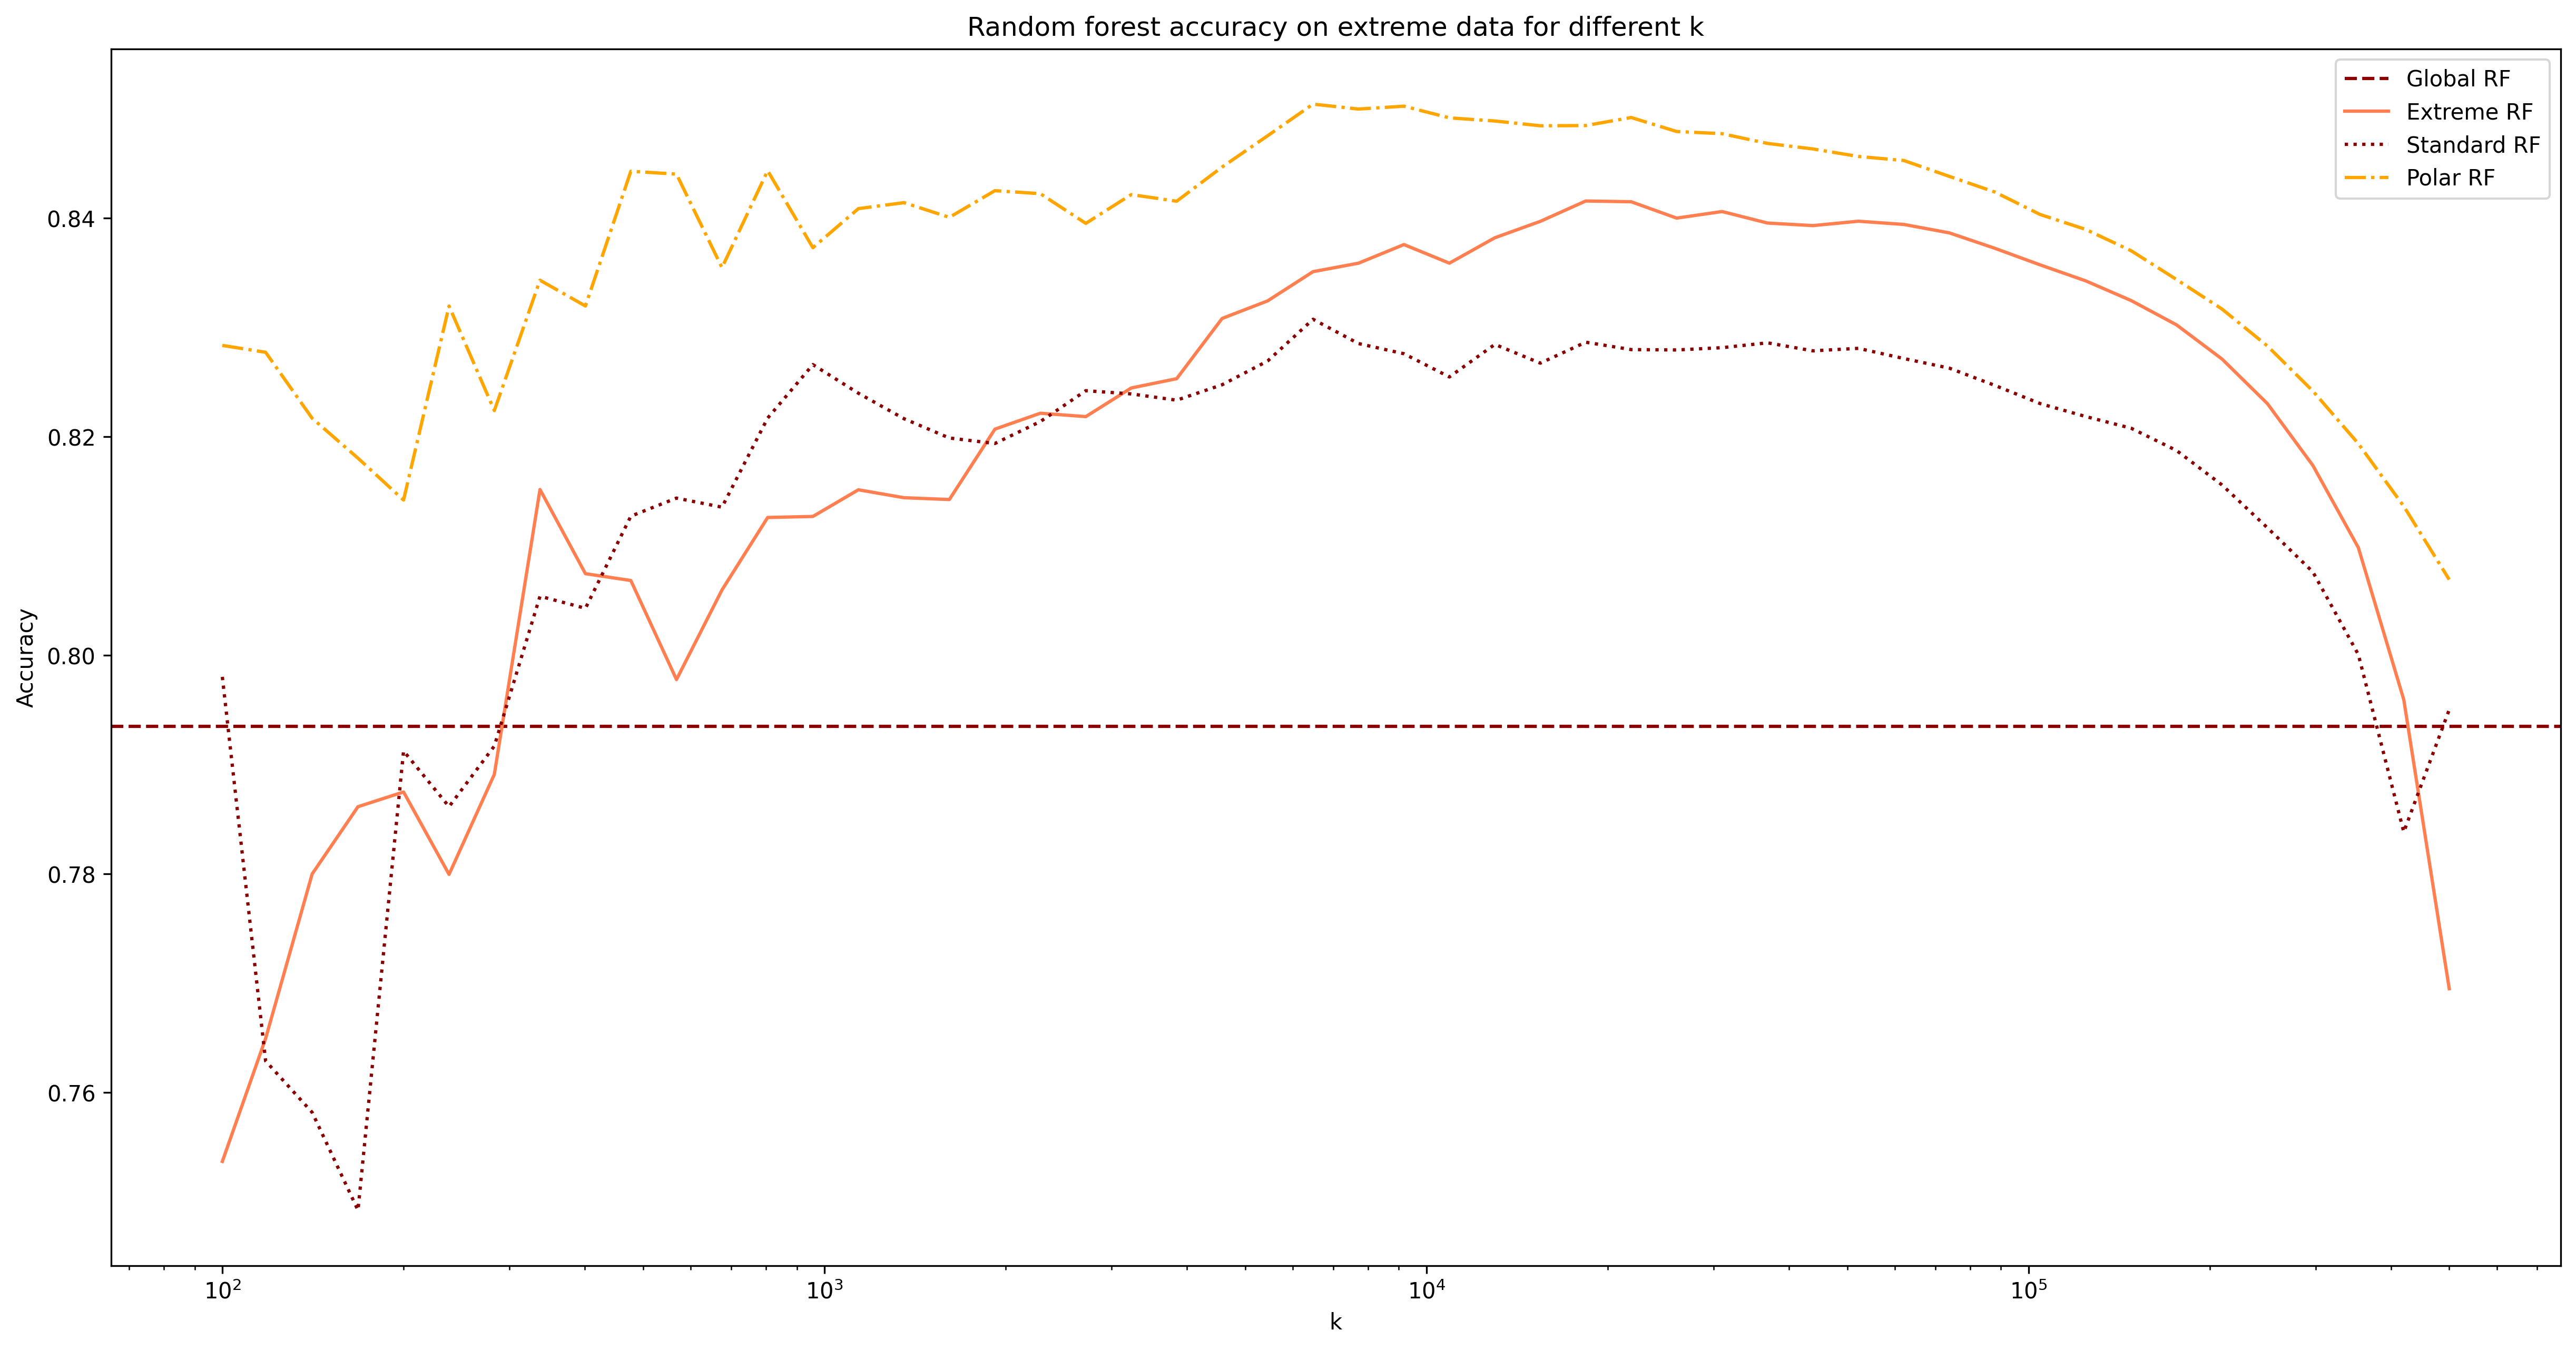

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10), dpi=300)

plt.axhline(y=whole_accuracy, color="darkred", linestyle="--", label="Global RF")

sns.lineplot(x=ks, y=accuracies, label="Extreme RF", color="coral")
sns.lineplot(x=ks, y=accuracies_truncated, label="Standard RF", color="darkred", linestyle="dotted")
sns.lineplot(x=ks, y=accuracies_polar, label="Polar RF", color="orange", linestyle="dashdot")

plt.xscale("log")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Random forest accuracy on extreme data for different k")
# Chqnge order of legend
handles, labels = plt.gca().get_legend_handles_labels()
# order = [0, 6, 2, 4, 5, 3, 7, 1]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="best")
plt.legend(loc="best")
plt.savefig("comparison_complete_accuracy.png", dpi=300, transparent=True)



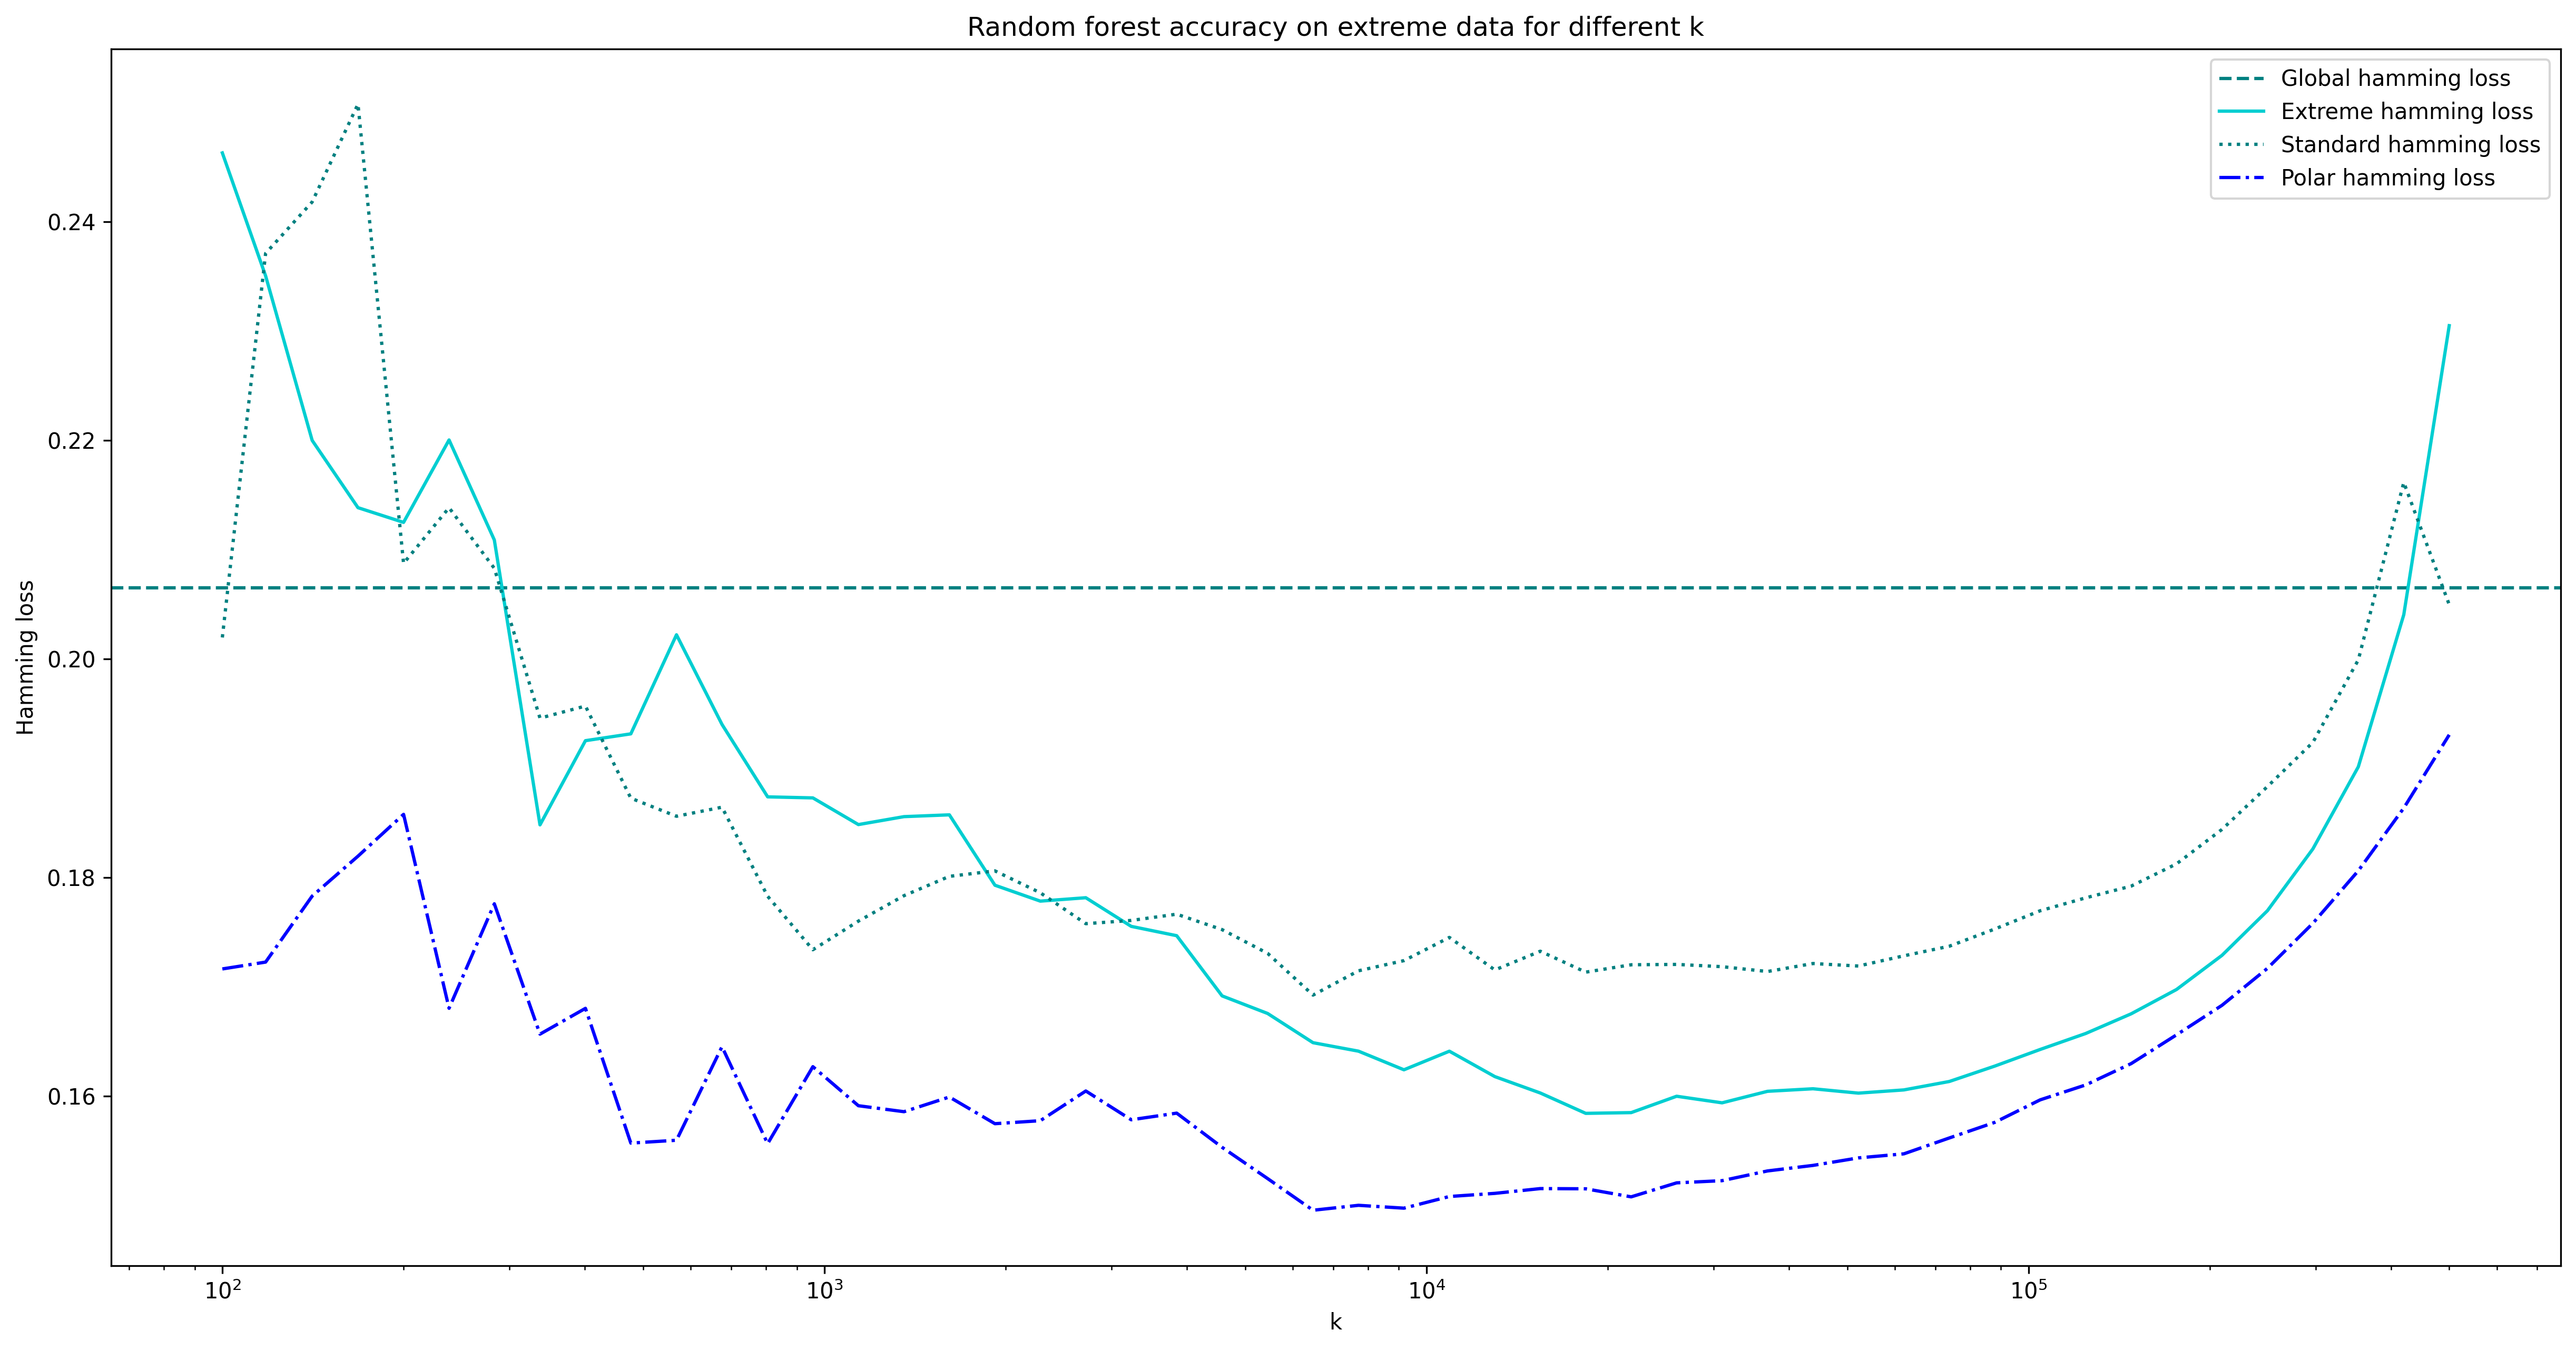

In [16]:
plt.figure(figsize=(20, 10), dpi=300)

plt.axhline(y=whole_hamming, color="teal", linestyle="--", label="Global hamming loss")
sns.lineplot(x=ks, y=hamming_losses, label="Extreme hamming loss", color="darkturquoise")
sns.lineplot(x=ks, y=hamming_losses_truncated, label="Standard hamming loss", color="teal", linestyle="dotted")
sns.lineplot(x=ks, y=hamming_losses_polar, label="Polar hamming loss", color="blue", linestyle="dashdot")

plt.xscale("log")
plt.xlabel("k")
plt.ylabel("Hamming loss")
plt.title("Random forest accuracy on extreme data for different k")
# Chqnge order of legend
# handles, labels = plt.gca().get_legend_handles_labels()
# order = [0, 6, 2, 4, 5, 3, 7, 1]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="best")
plt.legend(loc="best")
plt.savefig("comparison_complete_hamming.png", dpi=300, transparent=True)

